# Basic setup

## preprocessing

In [16]:
#!pip install datasets transformers scikit-learn

In [2]:
import pandas as pd
from datasets import Dataset
import transformers
from transformers import AutoTokenizer, AutoModel
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# benchmark files
train_file = "../data/train_benchmark.csv"
    
test_file = "../data/test_benchmark.csv"

In [6]:
df_train = pd.read_csv(train_file, sep=",")
df_test = pd.read_csv(test_file, sep=",")

df_train["Sentiment"] = df_train["Sentiment"].str.upper()
df_test["Sentiment"] = df_test["Sentiment"].str.upper()

# keeping only relevant data
df_train = df_train[["Utterance", "Sentiment"]].rename(columns={"Utterance": "text", "Sentiment": "sentiment_label"})
df_test = df_test[["Utterance", "Sentiment"]].rename(columns={"Utterance": "text", "Sentiment": "sentiment_label"})

In [8]:
df_train

,text,sentiment_label
0,also I was the point person on my company’s tr...,NEUTRAL
1,You must’ve had your hands full.,NEUTRAL
2,That I did. That I did.,NEUTRAL
3,So let’s talk a little bit about your duties.,NEUTRAL
4,My duties? All right.,POSITIVE
...,...,...
9984,You or me?,NEUTRAL
9985,"I got it. Uh, Joey, women don't have Adam's ap...",NEUTRAL
9986,"You guys are messing with me, right?",POSITIVE
9987,Yeah.,NEUTRAL


In [10]:
label2id = {'NEGATIVE': 0, 'NEUTRAL': 1, 'POSITIVE': 2}
id2label = {v: k for k, v in label2id.items()}

df_train["label"] = df_train["sentiment_label"].map(label2id)
df_test["label"] = df_test["sentiment_label"].map(label2id)


In [12]:
train_dataset = Dataset.from_pandas(df_train[["text", "label"]])
test_dataset = Dataset.from_pandas(df_test[["text", "label"]])

In [14]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [16]:
def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=128)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)


Map: 100%|████████████████████████| 2610/2610 [00:00<00:00, 32233.76 examples/s]


## model training

In [28]:
import evaluate
import numpy as np
model_path = "../bert/bert_1760_1900"  
model_name = "bert-1760"
task = "sentiment_analysis"
batch_size = 16

In [30]:
from transformers import (
    set_seed, 
    TrainingArguments, 
    Trainer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    AutoTokenizer
)

#put your seed
SEED = 23
set_seed(SEED)

args = TrainingArguments(
    f"{model_name}-finetuned-{task}",
    eval_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
    seed=SEED,
    report_to=None,
)


In [32]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
metric = evaluate.load("seqeval")
model = AutoModelForSequenceClassification.from_pretrained(
    model_path,
    num_labels=3,  # NEGATIVE, NEUTRAL, POSITIVE
    id2label={0:"NEGATIVE",1:"NEUTRAL",2:"POSITIVE"},
    label2id={"NEGATIVE":0,"NEUTRAL":1,"POSITIVE":2}
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ../bert/bert_1760_1900 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
label_list = ["NEGATIVE", "NEUTRAL", "POSITIVE"]

In [36]:
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

def compute_metrics(p):
    logits, labels = p
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    precision = precision_metric.compute(predictions=predictions, references=labels, average="weighted")
    recall = recall_metric.compute(predictions=predictions, references=labels, average="weighted")
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="weighted")
    return {
        "accuracy": accuracy["accuracy"],
        "precision": precision["precision"],
        "recall": recall["recall"],
        "f1": f1["f1"],
    }

In [37]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,       
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

/var/folders/pk/23rj3vrj73x83046rkqn9g100000gn/T/ipykernel_3023/601068247.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [40]:
trainer.train()

/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.856000,0.765442,0.683142,0.680730,0.683142,0.667453
2,0.738100,0.764711,0.685441,0.687201,0.685441,0.683772
3,0.651600,0.777415,0.698084,0.696019,0.698084,0.696660


/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Use

TrainOutput(global_step=1875, training_loss=0.7182211181640625, metrics={'train_runtime': 2539.6229, 'train_samples_per_second': 11.8, 'train_steps_per_second': 0.738, 'total_flos': 1971179947263744.0, 'train_loss': 0.7182211181640625, 'epoch': 3.0})

In [42]:
trainer.save_model('TuringBERT_benchmark_model')
trainer.tokenizer.save_pretrained('TuringBERT_benchmark_model')

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


('TuringBERT_benchmark_model/tokenizer_config.json',
 'TuringBERT_benchmark_model/special_tokens_map.json',
 'TuringBERT_benchmark_model/vocab.txt',
 'TuringBERT_benchmark_model/added_tokens.json',
 'TuringBERT_benchmark_model/tokenizer.json')

In [44]:
model = AutoModelForTokenClassification.from_pretrained("TuringBERT_benchmark_model")
tokenizer = AutoTokenizer.from_pretrained("TuringBERT_benchmark_model")

In [46]:
trainer.evaluate()

/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.7774153351783752,
 'eval_accuracy': 0.6980842911877395,
 'eval_precision': 0.6960191971039309,
 'eval_recall': 0.6980842911877395,
 'eval_f1': 0.6966602614880408,
 'eval_runtime': 52.5471,
 'eval_samples_per_second': 49.67,
 'eval_steps_per_second': 3.121,
 'epoch': 3.0}

## model evaluation

In [50]:
import csv

def save_sentence_level_predictions(texts, predictions, gold_labels, label_list, output_file_path):
    """
    Save sentence-level predictions with their texts and gold labels to a TSV file.

    Args:
        texts: List of sentence strings.
        predictions: List or array of predicted label IDs (one per sentence).
        gold_labels: List or array of true label IDs (one per sentence).
        label_list: List of string labels, where index corresponds to label ID.
        output_file_path: Path to save the TSV file.

    Returns:
        None
    """
    with open(output_file_path, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f, delimiter='\t')
        writer.writerow(['sentence', 'prediction', 'gold_label'])

        for text, pred_id, gold_id in zip(texts, predictions, gold_labels):
            pred_label = label_list[pred_id]
            gold_label = label_list[gold_id]
            writer.writerow([text, pred_label, gold_label])

    print(f"Sentence-level results saved to {output_file_path}")


In [52]:
predictions_raw, labels, _ = trainer.predict(test_dataset)
predictions = np.argmax(predictions_raw, axis=1)  # shape (num_samples,)

# Assuming you have the original sentences:
texts = [example['text'] for example in test_dataset]

save_sentence_level_predictions(texts, predictions, labels, label_list, "TuringBERT_benchmark_predictions.tsv")


/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Sentence-level results saved to TuringBERT_benchmark_predictions.tsv


In [54]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_sentence_predictions(predictions, labels, label_list):
    """
    Evaluate sentence-level predictions and print metrics.

    Args:
        predictions: numpy array or list of predicted label IDs
        labels: numpy array or list of true label IDs
        label_list: list of label strings, e.g. ["NEGATIVE", "NEUTRAL", "POSITIVE"]
    """
    # Convert IDs to label strings
    pred_labels = [label_list[p] for p in predictions]
    true_labels = [label_list[l] for l in labels]

    accuracy = accuracy_score(true_labels, pred_labels)
    report = classification_report(true_labels, pred_labels, target_names=label_list, digits=4)

    cm = confusion_matrix(true_labels, pred_labels, labels=label_list)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_list)

    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:\n", report)
    disp.plot(cmap=plt.cm.Purples, xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.show()


Accuracy: 0.6981
Classification Report:
               precision    recall  f1-score   support

    NEGATIVE     0.6469    0.6026    0.6240       833
     NEUTRAL     0.7676    0.7970    0.7820      1256
    POSITIVE     0.6019    0.6123    0.6070       521

    accuracy                         0.6981      2610
   macro avg     0.6721    0.6706    0.6710      2610
weighted avg     0.6960    0.6981    0.6967      2610



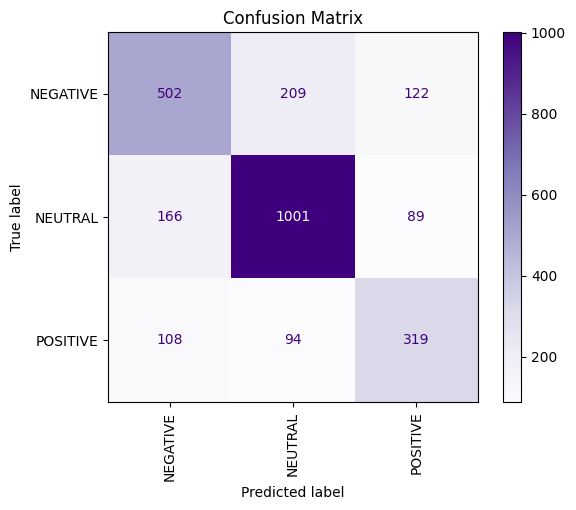

In [56]:
evaluate_sentence_predictions(predictions, labels, label_list)
